In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [5]:
import gc

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

train_dataset = "C:/Users/Gautam/OneDrive/Desktop/microsoft cybersecurity/GUIDE_Train.csv"
chunks = []

try:
    for chunk in pd.read_csv(train_dataset, chunksize=100000, low_memory=False, encoding='utf-8'):
        try:
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        except pd.errors.ParserError:
            pass  # Skip this chunk if there's a parsing error
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.EmptyDataError:
    print("File is empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Concatenate all chunks if there's any valid data
if chunks:
    train = pd.concat(chunks, ignore_index=True)
    # Clean up memory
    del chunks
    gc.collect()
    print("Data concatenated successfully.")
else:
    print("No valid data to concatenate.")

Data concatenated successfully.


In [6]:
train.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [7]:
train.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [9]:
train.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


In [10]:
train.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [11]:
# Droping Columns with More Than 50% Missing Values:
train.drop(columns=['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 
                       'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'], 
               axis=1, inplace=True)

In [12]:
train.isnull().sum()

Id                        0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
IncidentGrade         51340
EntityType                0
EvidenceRole              0
DeviceId                  0
Sha256                    0
IpAddress                 0
Url                       0
AccountSid                0
AccountUpn                0
AccountObjectId           0
AccountName               0
DeviceName                0
NetworkMessageId          0
RegistryKey               0
RegistryValueName         0
RegistryValueData         0
ApplicationId             0
ApplicationName           0
OAuthApplicationId        0
FileName                  0
FolderPath                0
ResourceIdName            0
OSFamily                  0
OSVersion                 0
CountryCode               0
State                     0
City                      0
dtype: int64

In [13]:
# Fill NaN values in 'IncidentGrade' with the mode
mode_value = train['IncidentGrade'].mode()[0]  # Get the mode of the column
train['IncidentGrade'].fillna(mode_value, inplace=True)

C:\Users\Gautam\AppData\Local\Temp\ipykernel_15060\2387091400.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['IncidentGrade'].fillna(mode_value, inplace=True)


In [14]:

train.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [15]:

train.duplicated().sum()

MemoryError: Unable to allocate 72.6 MiB for an array with shape (9516837,) and data type int64

In [18]:
def optimize_data_types(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

train = optimize_data_types(train)
train = train.drop_duplicates()
print(f"Number of rows after removing duplicates: {train.shape[0]}")


Number of rows after removing duplicates: 8970539


In [19]:
# Target variable distribution
print("Target variable distribution:")
train['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3875534
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

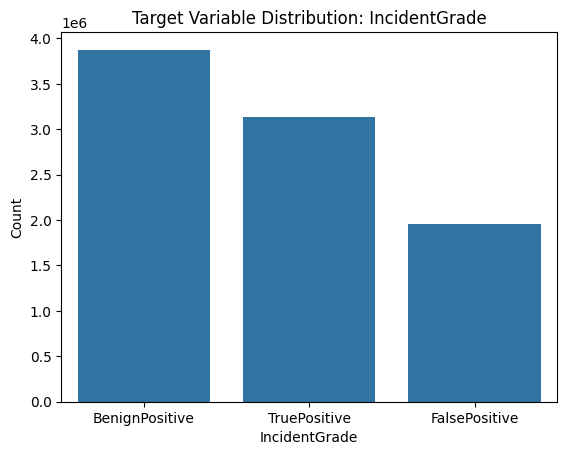

In [20]:
sns.countplot(data=train, x='IncidentGrade', order=train['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

Feature Exploration

In [21]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['Year'] = train['Timestamp'].dt.year
train['Month'] = train['Timestamp'].dt.month
train['Day'] = train['Timestamp'].dt.day
train['Hour'] = train['Timestamp'].dt.hour

train.drop(columns='Timestamp',inplace=True)

C:\Users\Gautam\AppData\Local\Temp\ipykernel_15060\2692684695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Timestamp'] = pd.to_datetime(train['Timestamp'])
C:\Users\Gautam\AppData\Local\Temp\ipykernel_15060\2692684695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Year'] = train['Timestamp'].dt.year
C:\Users\Gautam\AppData\Local\Temp\ipykernel_15060\2692684695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [22]:
train.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

Exploratory Data Analysis (EDA) - Visualizing Distributions

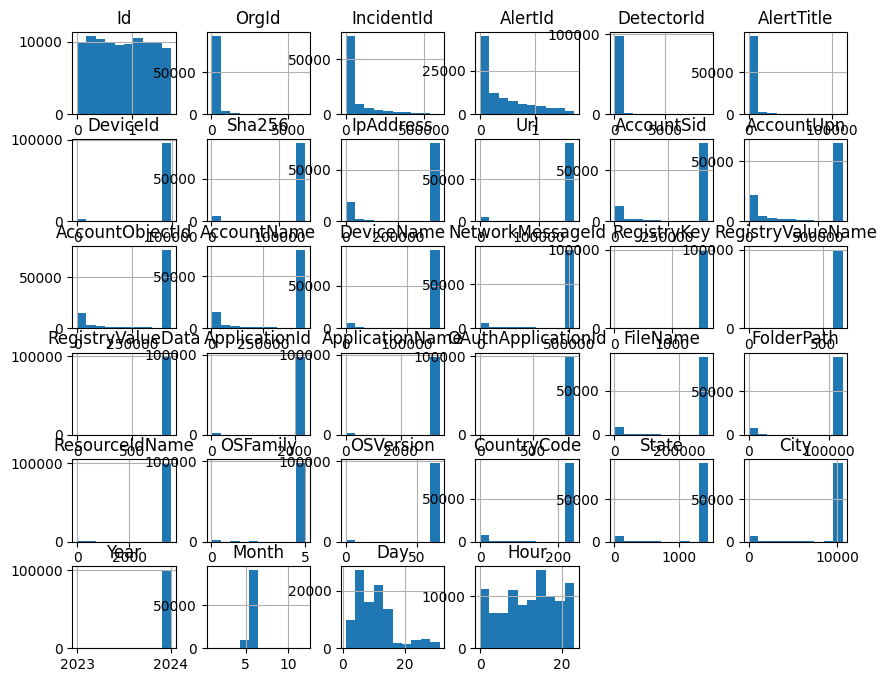

In [24]:
# Take a random sample of 100,000 rows
train_sample = train.sample(n=100000, random_state=42)

train_sample.hist(figsize=(10, 8))
plt.show()

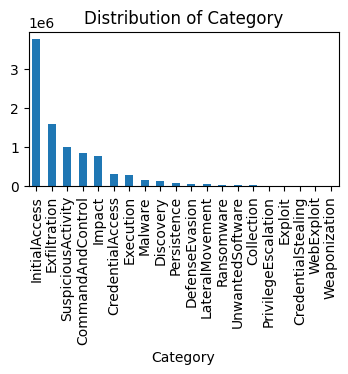

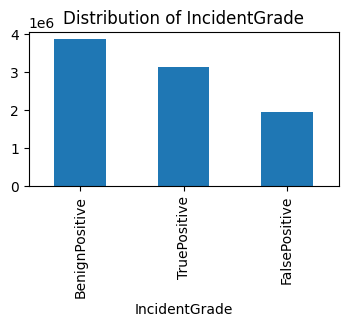

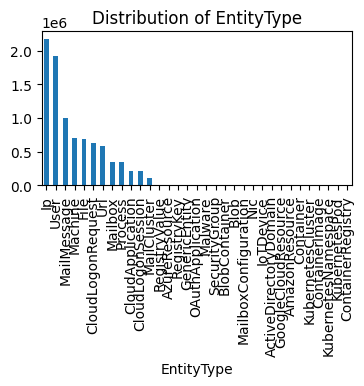

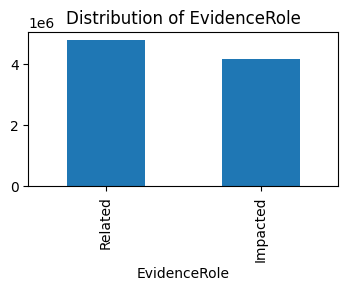

In [25]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = train.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    train[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

Visualizing the Data to Identify Outliers

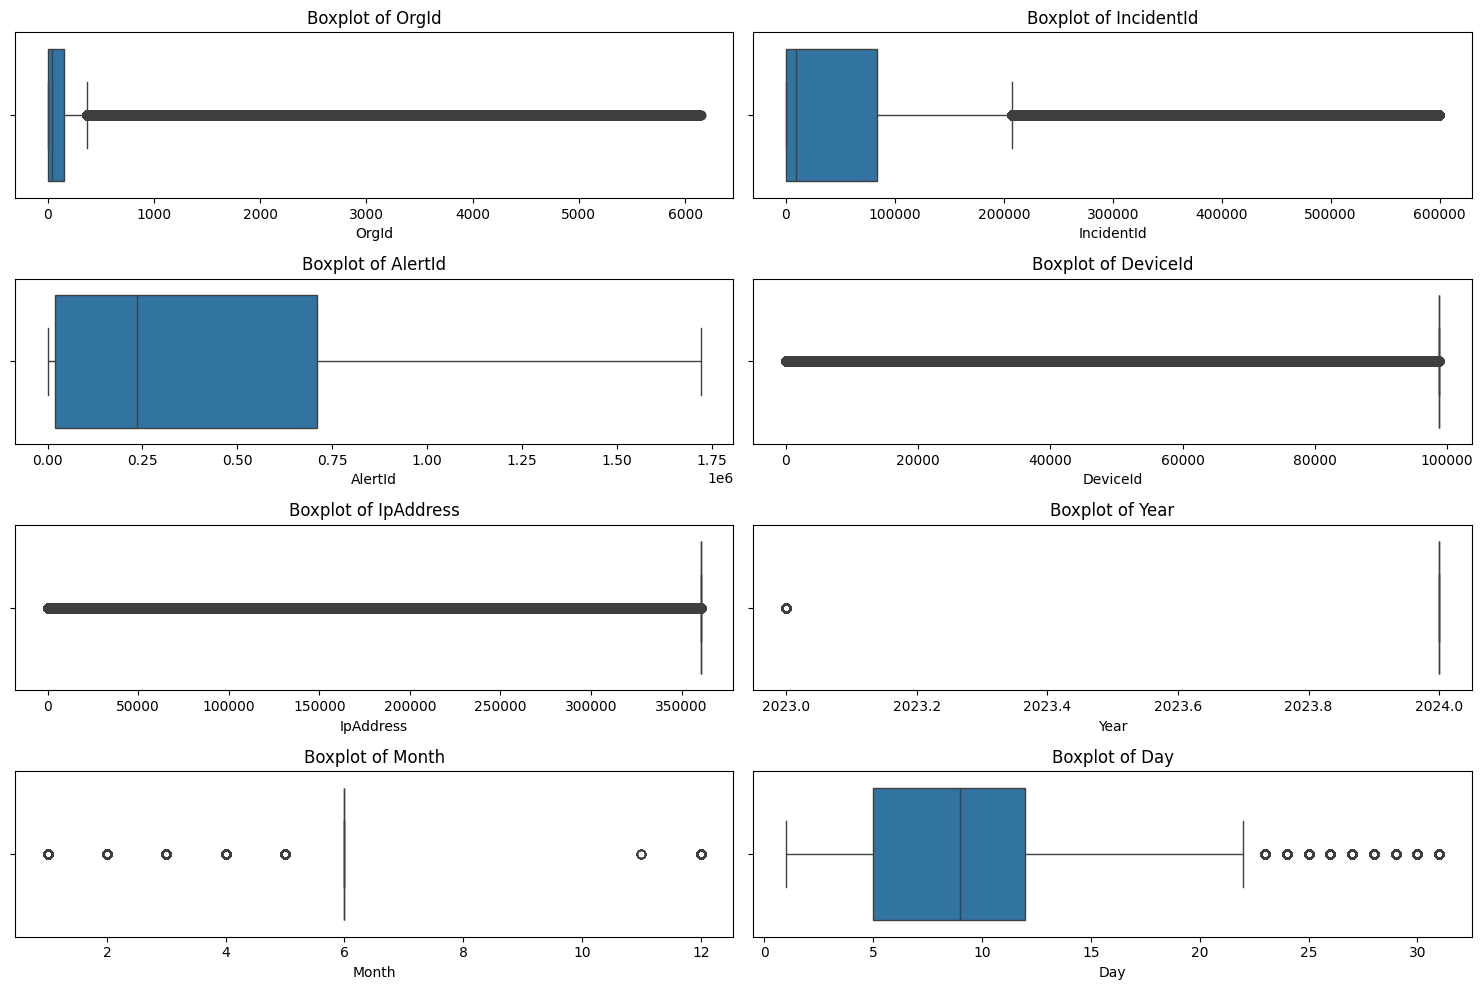

In [26]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


Correlation Analysis

In [30]:
train_data1 = train.sample(n=100000, random_state=42).copy()  # Sample 100,000 rows



In [ ]:
# List of Numerical columns in DataFrame
numeric_columns = train.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'DetectorId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ResourceIdName', 'OSFamily', 'OSVersion',
       'CountryCode', 'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

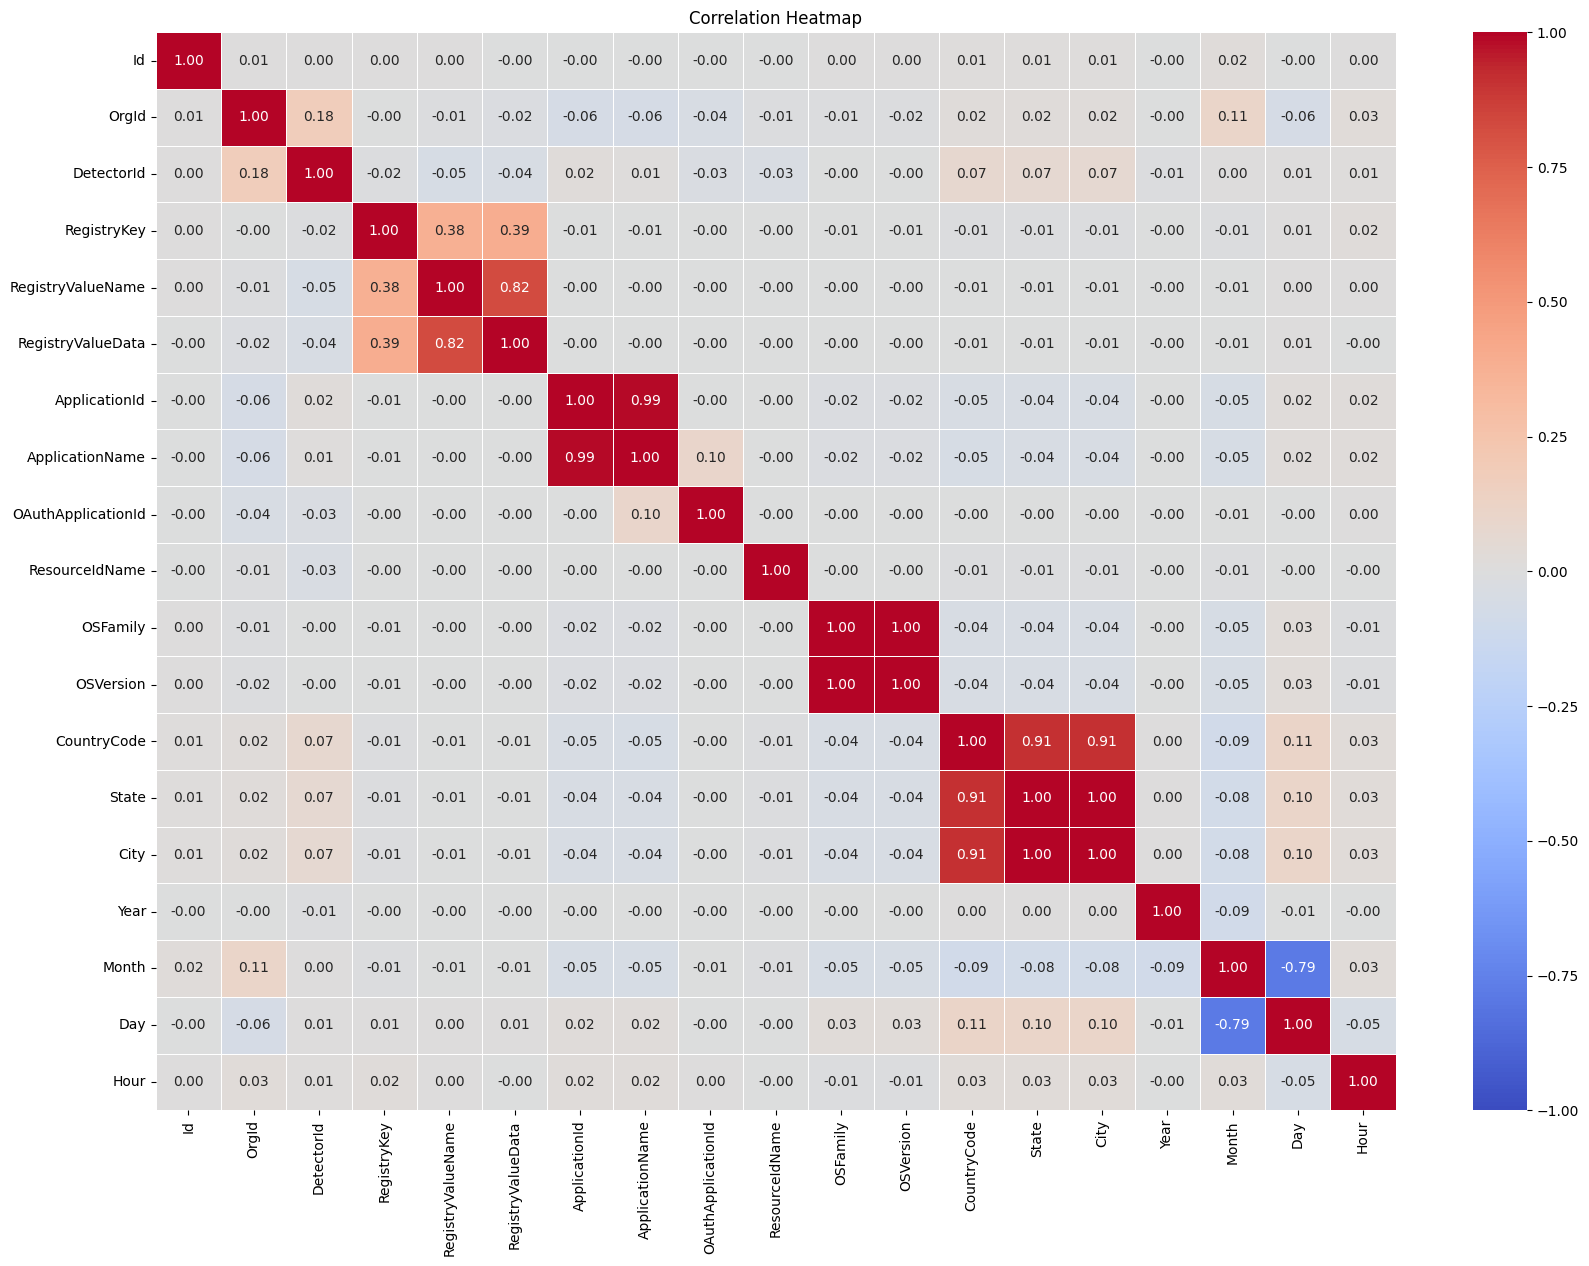

In [ ]:

# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Feature Importance via Random Forest

In [ ]:
# ID columns that don't help in model training
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']


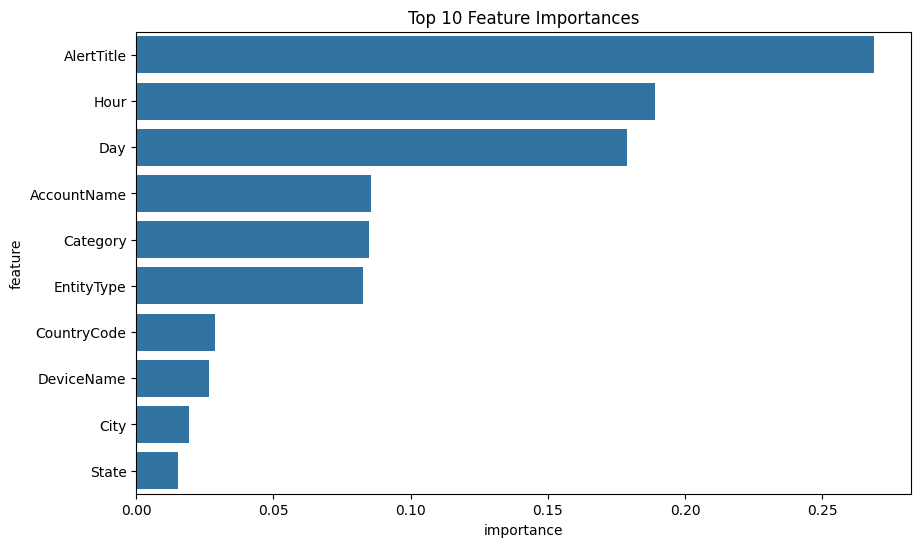

In [ ]:
train_sample = train.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [ ]:
#total df imp
imp_features= [
    'Alert Title', 'Hour', 'Day', 'AccountName', 'Category', 'EntityType', 'DeviceName', 'CountryCode', 'State', 'City']

In [ ]:
print(train.columns)
train.shape

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 38)

In [ ]:
train.nunique()

Id                     730778
OrgId                    5769
IncidentId             466151
AlertId               1265644
DetectorId               8428
AlertTitle              86149
Category                   20
IncidentGrade               3
EntityType                 33
EvidenceRole                2
DeviceId                75826
Sha256                 106416
IpAddress              285957
Url                    123252
AccountSid             358401
AccountUpn             530183
AccountObjectId        343516
AccountName            368250
DeviceName             114541
NetworkMessageId       375196
RegistryKey              1341
RegistryValueName         525
RegistryValueData         699
ApplicationId            1728
ApplicationName          2681
OAuthApplicationId        703
FileName               222085
FolderPath              87832
ResourceIdName           2309
OSFamily                    6
OSVersion                  58
CountryCode               236
State                    1368
City      

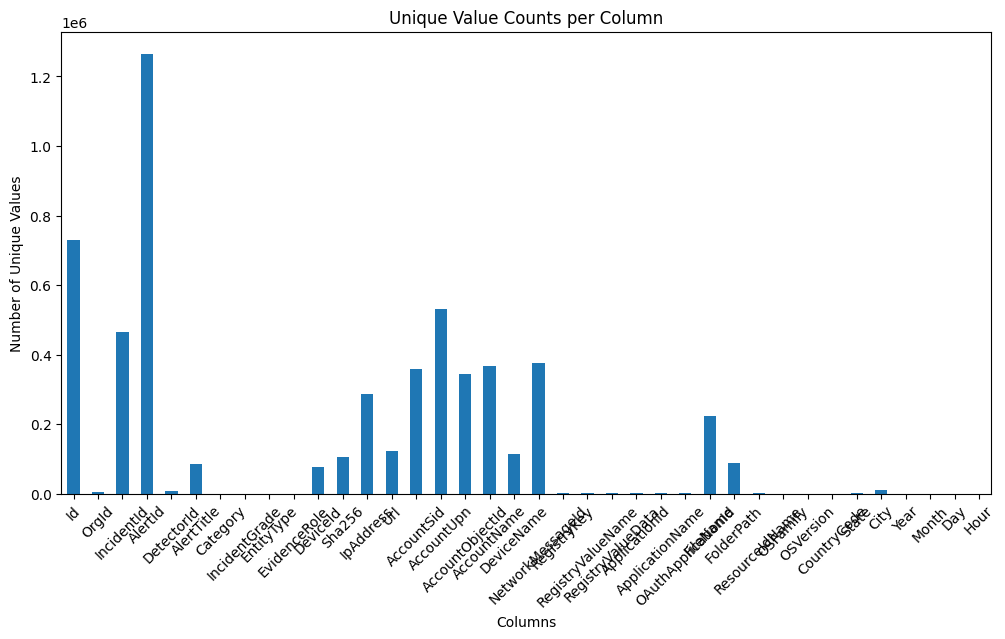

In [ ]:
unique_counts = train.nunique()
unique_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Unique Value Counts per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.show()

In [ ]:
train['AlertTitle'].value_counts()

AlertTitle
0         1320736
2          597423
1          480010
4          412029
3          412025
           ...   
104011          1
110908          1
106120          1
112088          1
112969          1
Name: count, Length: 86149, dtype: int64

In [ ]:
train['Url'].value_counts()

Url
160396    8381106
0            8195
1            6607
2            5264
6            4238
           ...   
90529           1
120679          1
93239           1
107481          1
137238          1
Name: count, Length: 123252, dtype: int64

In [ ]:
train['DeviceName'].value_counts().head(20)

DeviceName
153085    8274527
0            4376
1            3944
5            2153
4            2152
6            1879
13           1727
7            1631
10           1545
9            1519
8            1512
11           1284
12           1251
16           1187
15           1095
14           1094
22           1021
28            932
20            920
17            813
Name: count, dtype: int64

In [ ]:

train['City'].value_counts()

City
10630    8342804
0         103145
1          22075
2          19195
3          15787
          ...   
5256           1
9303           1
9449           1
7797           1
9954           1
Name: count, Length: 9342, dtype: int64

In [ ]:
train['OrgId'].value_counts()

OrgId
0       844839
2       236415
1       210086
3       189731
5       173301
         ...  
6119         1
6109         1
6070         1
6065         1
6116         1
Name: count, Length: 5769, dtype: int64

In [ ]:
train['AccountSid'].value_counts().head(20)

AccountSid
441377    6857115
0           14469
1            8978
2            6017
3            5262
4            3770
5            3596
7            3144
8            2832
11           2552
6            2353
9            2349
12           2129
15           1993
14           1986
17           1930
18           1924
16           1878
19           1859
21           1847
Name: count, dtype: int64

In [ ]:
train['AccountSid'].value_counts()

AccountSid
441377    6857115
0           14469
1            8978
2            6017
3            5262
           ...   
393140          1
183936          1
367952          1
398881          1
228045          1
Name: count, Length: 358401, dtype: int64

In [ ]:
train['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    3875534
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

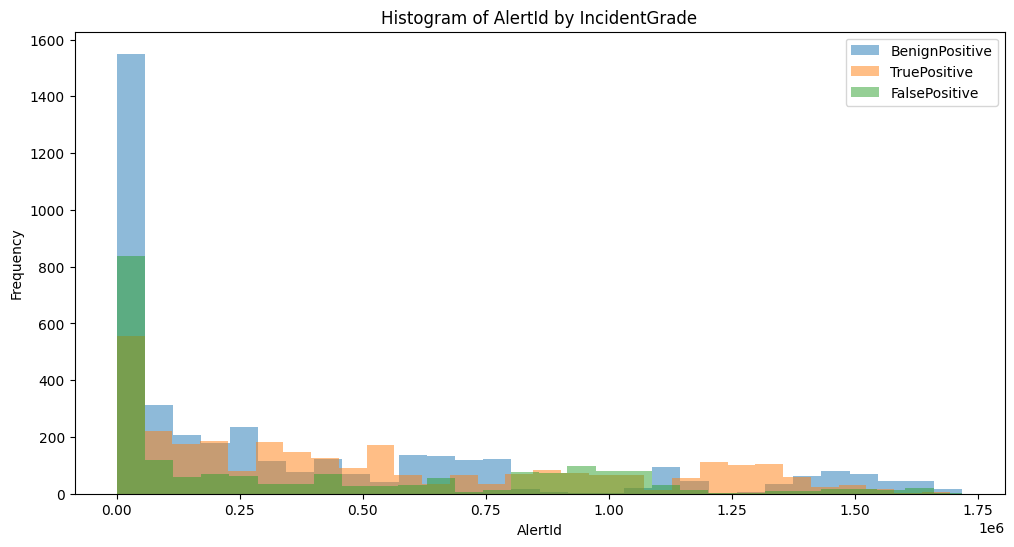

In [ ]:
train_sample = train_data1.sample(frac=0.001, random_state=42)

plt.figure(figsize=(12, 6))
for grade in train_sample['IncidentGrade'].unique():
    subset = train_sample[train_sample['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

In [ ]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
train.drop(columns=columns_to_drop, inplace=True)

In [ ]:
print(train.columns)
train.shape


Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 16)

In [ ]:
def handle_outliers(df, iqr_multiplier=3.0):
    numeric_features = df.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
    for col in numeric_features.columns:
        # IQR method
        Q1 = numeric_features[col].quantile(0.25)
        Q3 = numeric_features[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        
        # Quantile Capping
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=q_low, upper=q_high)
        
    return df

In [ ]:
train.head()

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,6,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,31,6,3,2024,6,4,6
1,43,Exfiltration,FalsePositive,User,Impacted,160396,24887,153085,5,242,1445,10630,2024,6,14,3
2,298,InitialAccess,FalsePositive,Url,Related,68652,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,13,453297,153085,5,242,1445,10630,2024,6,10,16
4,74,Execution,TruePositive,User,Impacted,160396,479,153085,5,242,1445,10630,2024,6,15,1


In [ ]:
print(train.columns)
train.shape

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8970539, 16)


Encoding Categorical Variables


Label Encoding for Ordinal Variables \ One-hot encoding for nominal columns

In [ ]:

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8970539 entries, 0 to 9516836
Data columns (total 16 columns):
 #   Column         Dtype   
---  ------         -----   
 0   AlertTitle     int32   
 1   Category       object  
 2   IncidentGrade  category
 3   EntityType     object  
 4   EvidenceRole   category
 5   Url            int32   
 6   AccountName    int32   
 7   DeviceName     int32   
 8   OSFamily       int8    
 9   CountryCode    int16   
 10  State          int16   
 11  City           int16   
 12  Year           int32   
 13  Month          int32   
 14  Day            int32   
 15  Hour           int32   
dtypes: category(2), int16(3), int32(8), int8(1), object(2)
memory usage: 556.1+ MB


In [ ]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [ ]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = train[column].value_counts()
    top_categories = category_counts.nlargest(8).index
    train[column] = train[column].where(train[column].isin(top_categories), 'Others')

# Now verifing the changes
train

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,6,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,Others,6,3,2024,6,4,6
1,Others,Exfiltration,FalsePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,14,3
2,Others,InitialAccess,FalsePositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,10,16
4,Others,Execution,TruePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,6,InitialAccess,TruePositive,CloudLogonRequest,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,15
9516833,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,6,9
9516834,Others,Exfiltration,BenignPositive,MailMessage,Impacted,160396,453297,153085,5,242,1445,10630,2024,6,11,22
9516835,Others,Impact,BenignPositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,5,20,23


In [ ]:
train.head()


NameError: name 'train' is not defined

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Function to apply one-hot encoding chunk-wise
def optimized_one_hot_encoding_chunkwise(file_path, categorical_columns, target_column, chunksize=100000):
    chunks = []
    le = LabelEncoder()  # Initialize the LabelEncoder for the target variable

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        # Encode the target column
        chunk[target_column] = le.fit_transform(chunk[target_column])
        
        for col in categorical_columns:
            # Apply one-hot encoding column by column
            dummies = pd.get_dummies(chunk[col], prefix=col, drop_first=True, sparse=True)
            chunk = pd.concat([chunk, dummies], axis=1)
            chunk.drop(columns=[col], inplace=True)
        
        # Append the processed chunk
        chunks.append(chunk)

    # Concatenate all chunks to form the final dataset
    return pd.concat(chunks, ignore_index=True)

# Define the file path and columns
file_path = "C:/Users/Gautam/OneDrive/Desktop/microsoft cybersecurity/GUIDE_Train.csv"
target_column = "IncidentGrade"
categorical_columns = ["Category", "EntityType"]  # Replace with actual column names

# Process the dataset chunk-wise
train = optimized_one_hot_encoding_chunkwise(file_path, categorical_columns, target_column)

# Display memory usage
print(f"Memory usage after processing: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


In [ ]:

train

In [ ]:
from sklearn.preprocessing import StandardScaler

# Define the ID columns if you haven't already (replace 'ID' with the actual column names you want to exclude)
id_columns = ['ID']  # Replace 'ID' with the actual ID columns in your dataset

# Select numeric columns and exclude ID columns for scaling
numeric_features = train.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float64']).drop(columns=id_columns, errors='ignore')

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on numeric features, then update train_data with scaled values
train[numeric_features.columns] = scaler.fit_transform(numeric_features)

# Confirm scaling (optional)
print(train.head())

In [ ]:
train

Saving the Cleaned Train Data set

In [ ]:
def optimize_dataframe(df):
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')
    return df

train = optimize_dataframe(train)


In [ ]:
chunk_size = 100000
for i in range(0, len(train), chunk_size):
    chunk = train.iloc[i:i + chunk_size]
    # Process each chunk as needed


In [ ]:
train.reset_index(drop=True, inplace=True)


In [ ]:
#Saving the data using Joblib
joblib.dump(train, 'encoded_train_data.joblib')

In [ ]:

# Loading the data using Joblib
train = joblib.load('encoded_train_data.joblib')

In [ ]:

train.head()

In [ ]:
print(train.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

In [ ]:
train.to_csv("final_train_data.csv", index=False)

train =pd.read_csv("final_train_data.csv")